<a href="https://colab.research.google.com/github/AsafEl94/Multi-Class-DogBreed-Classifier/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# 🐶End-to-end Multi-class Dog Breed Classification

This notebook builds an End-to-end multi-class image classifier using `TensorFlow 2.0` and `TensorFlow Hub`.

## 1. Problem

Identifying the breed of a dog given the image of a dog.

"When I'm sitting at the cafe and I take a photo of a dog I want to know what breed of dog it is."

## 2. Data

The data we're using is from Kaggle's dog breed identification competition:
https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image:
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) do it's porbably best we'll usr Deep Learning\Transfer Learning.
* There are 120 dog breeds (This means there are 120 different classes)
* There are around 10,000+ images in the training set (This images has labales).
* There are around 10,000+ images in the test set (Have no labels cause we need to predict them).

In [2]:
# Unzipping the uploaded data into Google Drive
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

## Get our Workspace ready

In [3]:
## Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version", tf.__version__)
print("TF Hub version", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSSSSSSS!!!)") if tf.config.list_physical_devices("GPU") else "not available :("


TF version 2.13.0
TF Hub version 0.14.0
GPU available (YESSSSSSSSS!!!)


## Getting our data ready (turning it into tensors)

With all Machine Learning models our data has to be in numerical format, turning our images into tensors (numerical features).

Let's start with accesing the data and check the labels

In [4]:
# Check out the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: >

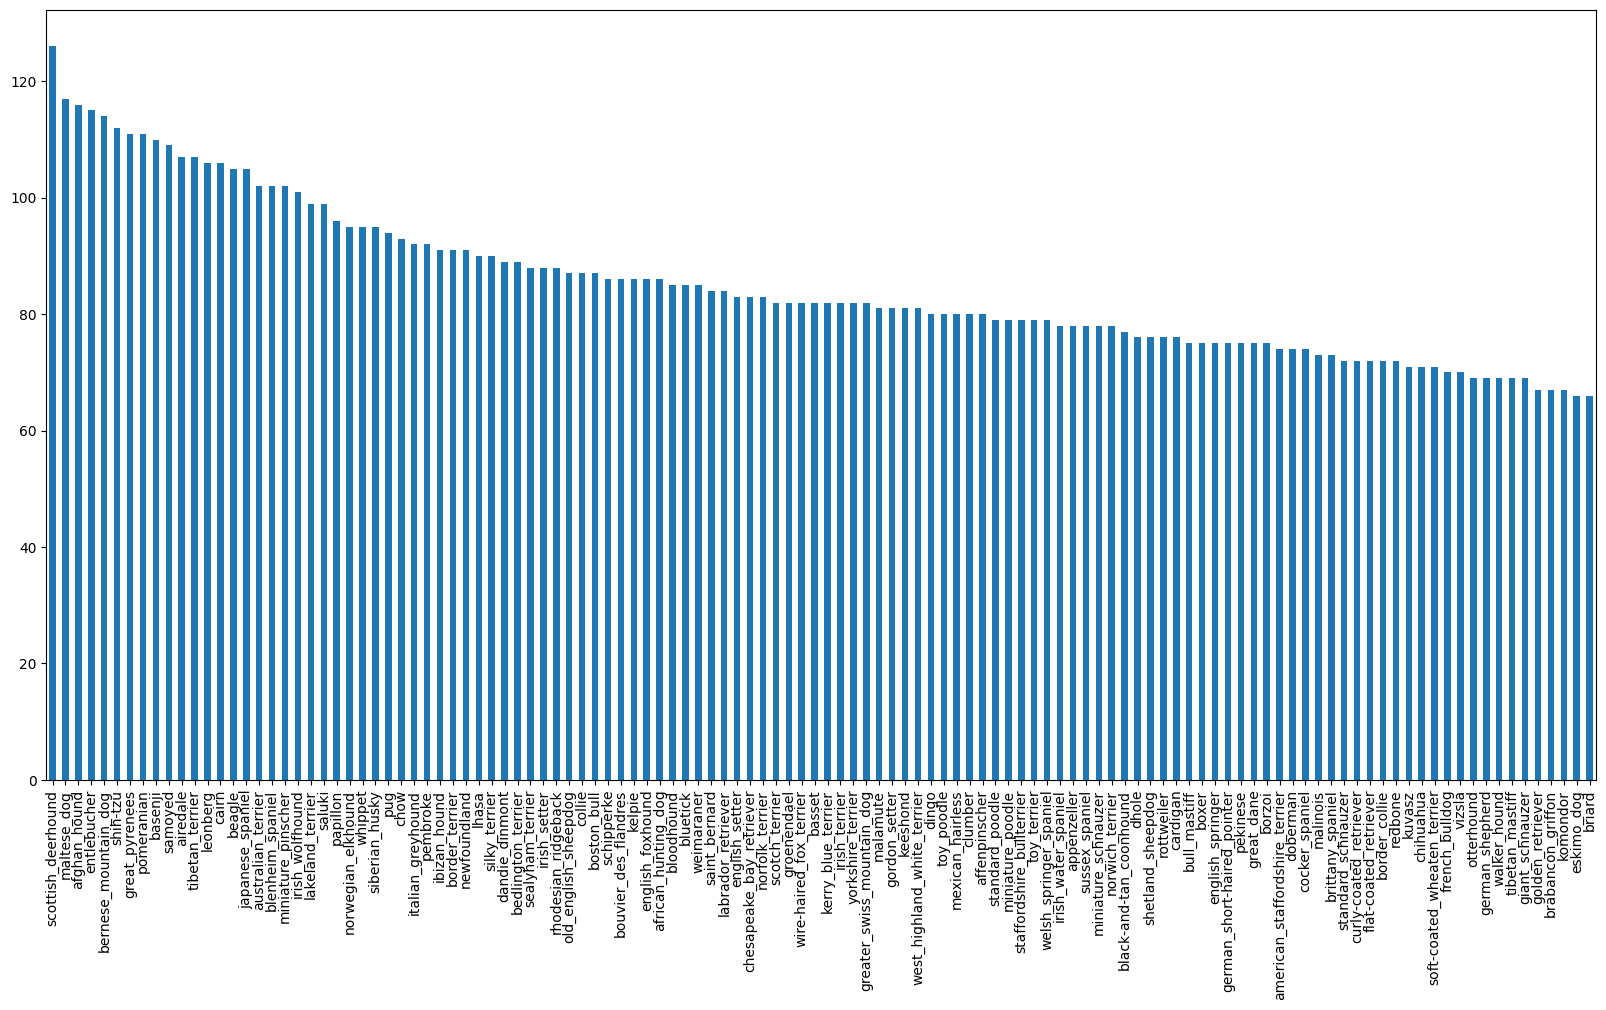

In [6]:
# How many images are there for each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [7]:
# Median is a bit more robust than mean
# We'll also looking for ~10-100 samples per breed (as described in tensorflow 2.x image classifier documentation)
labels_csv["breed"].value_counts().median()

82.0

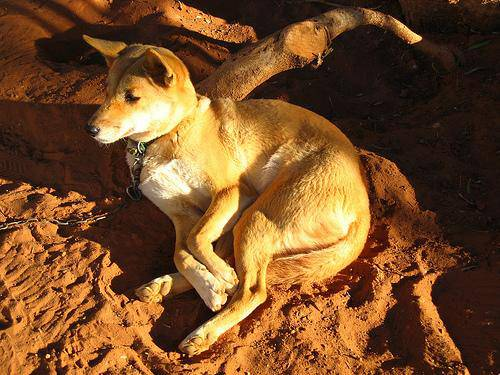

In [8]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of al our image file  pathnames.



In [9]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [10]:
# create pathnames from image ID's
filenames = ["drive/MyDrive/Dog Vision/train/" +fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")


Filenames match actual amount of files!!! Proceed.


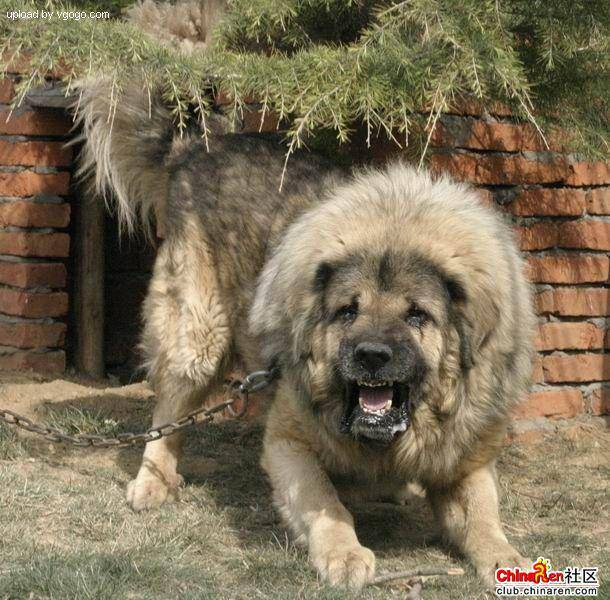

In [12]:
# One more check
Image(filenames[9000])

In [13]:
# What a beautiful beast, what's his breed?
labels_csv["breed"][9000]

'tibetan_mastiff'

We arranged our file pathes in a list, now lwt's handle our labels

In [14]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# Last check
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Check data directions, ther's no match.")

Number of labels matches number of filenames.


In [17]:
# Find the unique label value
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# turn every label into bolean array
bolean_labels =[label== unique_breeds for label in labels]
bolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(bolean_labels)

10222

In [22]:
# Example: Turning bolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(bolean_labels[0].argmax()) # Index where bolean occurs in bolean array
print(bolean_labels[0].astype(int)) # There will be a 1 where the samplee label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [23]:
print(labels[2])
print(bolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [24]:
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Wer're going to start off expirmenting with ~1000 umages and increse as needed

In [25]:
X = filenames
y = bolean_labels

In [26]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param{type:"slider", min:1000, max:10000, step:1000}


In [27]:
# Let's split our data into train and validation
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state = 42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [28]:
# Let's have a look at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images (turning images into Tensors)

To preprocess our images into ttensorss we're going to write a function that does a few things:
1. TTake an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modifies `image`

In [29]:
# Convert an image to a numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [30]:
image.max(), image.min()

(255, 0)

In [31]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [32]:
# Turn imagee to a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image look like as a Tensor, let's make a function to preproces them.
1. TTake an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`


In [33]:
# Define image size
IMG_SIZE = 224

# Make all our photos in the current size by function
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  #Turn the jpeg image into numerical Tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels = 3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desireed value (224, 224)
  image = tf.image.resize(image, size = [img_size, img_size])

  return image

## Turning our data into batches (<32)

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be)

In order to usr TensorFlow effectively. we need our data in the form of Tensor tuples which look like this: (image, label)

In [34]:
# Create a simple func. to return a tuple
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [35]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data to a tuples of Tensors in the form: `(image, label)`, Let's make a func. to turn all of our data (`X` and `y`) into batches

In [36]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Create batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as inputs (no labels).
  """
  # If the data is a test data set we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Onlt file path (no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn file pathes and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling path names and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    #Create (image, label) tuple, this also turns the image path into preprocessed image
    data = data.map(get_image_label)

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [37]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [38]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data batches

Our data is now in battches, however this can be a bit hard to understand/compreehens, let's visualize them

In [39]:
import matplotlib.pyplot as plt

# Create a func. for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

In [40]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [41]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.41912642, 0.5658715 , 0.3277547 ],
          [0.41429928, 0.5538571 , 0.311674  ],
          [0.44605643, 0.5791033 , 0.3296306 ],
          ...,
          [0.5397934 , 0.59477204, 0.36339948],
          [0.44101456, 0.5414349 , 0.2859376 ],
          [0.39584374, 0.5095692 , 0.25074568]],
 
         [[0.45222265, 0.58440524, 0.3635839 ],
          [0.42559996, 0.55639243, 0.32949525],
          [0.46348917, 0.58308434, 0.3446978 ],
          ...,
          [0.5314163 , 0.5925882 , 0.3526284 ],
          [0.44859833, 0.5514465 , 0.29681826],
          [0.41572073, 0.5294462 , 0.27634746]],
 
         [[0.4811124 , 0.5962122 , 0.4043792 ],
          [0.44178197, 0.55629045, 0.35055298],
          [0.46953785, 0.5760136 , 0.3534525 ],
          ...,
          [0.48757717, 0.5717647 , 0.31431553],
          [0.45695803, 0.5605757 , 0.31330827],
          [0.4443148 , 0.55719125, 0.30875808]],
 
         ...,
 
         [[0.34082794, 0.50174797, 0.25455344],
          [0.36067

In [42]:
len(train_labels), len(train_data)

(32, 25)

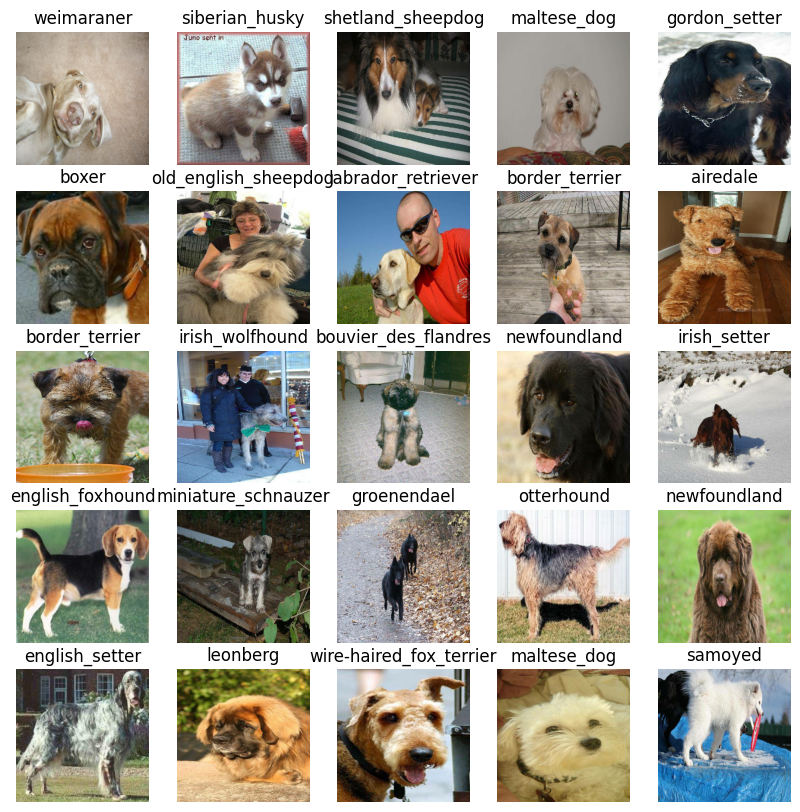

In [43]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

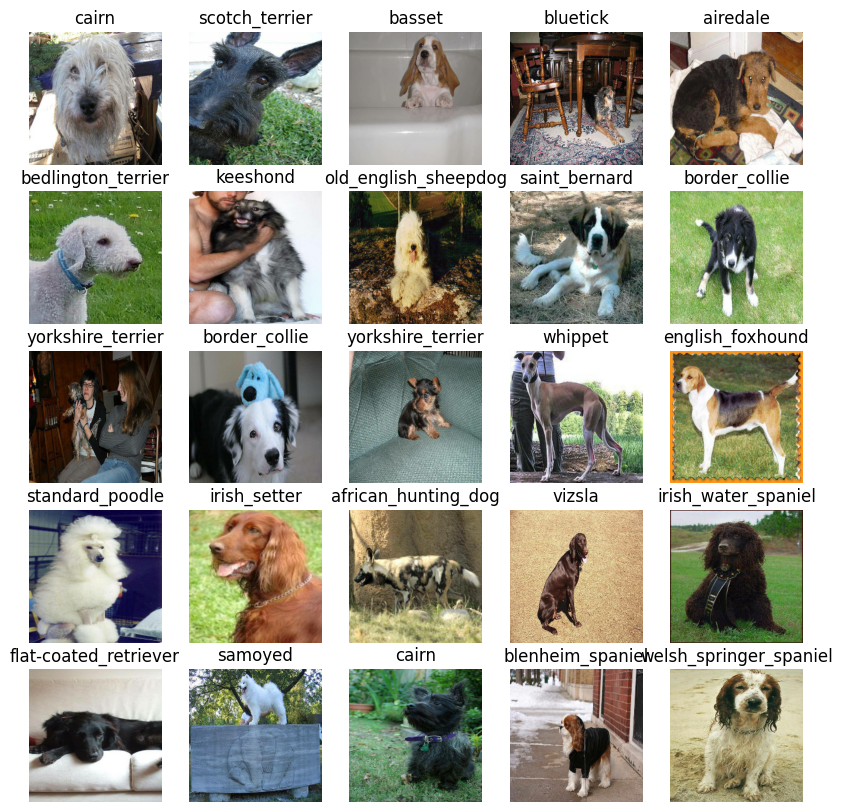

In [44]:
# Let's do the same for validation
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

And itt's not shuffled in each iteration as the training batch.

## Building a model
Before we build a model, rhere are few things we need to define:
* The input shape (images in the form of Tensors) of our model.
* The output shape (images in the form of Tensors) of our model.
* The URL of the model we wnt to use fro m TensorFlow HUB.

In [45]:
# Setup input shape `to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, highr, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE =len(unique_breeds)

# Setup model URL from TensorFlow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we got our inputs, outputs and model ready to go.
Let's put them together into a Keras Deep Learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Define the layers in a Keras model in a sequential fashion (do this first, then this, then that..)
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be gettting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [46]:
# Create a function which builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with:", model_url)

  #Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile thee model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer = tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics = ["accuracy"] # We'd like this to go up
  )

  #Build the model
  model.build(input_shape)

  return model

In [47]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

call backs are helper functions our model can use during training o do such things as: save progress, check its progress, or stop the model from training if it's not improving anymore.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

### TensorBoard callback

To setup a TensorBoard callback we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to the model fit function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after the model training)


In [48]:
# Load TensorBoard noterbook extension
%load_ext tensorboard

In [49]:
import datetime
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  #Create a log directory to store TensorBoard log:
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                        # Make it so the logs get tracked every timee we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callbacks

We'll use it to stop our model fron overfitting by stopping training when its evaluation metrics stops improving

In [50]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 epoches* of no improvements, *Epoch - A single run on all of the training data.

### Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [51]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [52]:
# CHECK TO MAKE SURE WE STRILL RUNNING ON A GPU
print("GPU", "available (Yes!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (Yes!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboars_callback()`
* Call the `fit()` function on our model passing it the train and validation data, number of epoches to train for (`NUM_EPOCHES`) and the callbacks we'd like to use.
* Return the model

In [53]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  #Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data, passisg it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])
  #Return the fitted model
  return model

In [54]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 119s 212ms/step - loss: 4.6334 - accuracy: 0.0825 - val_loss: 3.3918 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 3s 108ms/step - loss: 1.6576 - accuracy: 0.6862 - val_loss: 2.1533 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 3s 111ms/step - loss: 0.5817 - accuracy: 0.9312 - val_loss: 1.6764 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 4s 152ms/step - loss: 0.2597 - accuracy: 0.9887 - val_loss: 1.4893 - val_accuracy: 0.6600
Epoch 5/100
25/25 [==============================] - 3s 108ms/step - loss: 0.1482 - accuracy: 0.9987 - val_loss: 1.4190 - val_accuracy: 0.6850
Epoch 6/100
25/25 [==============================] - 3s 110ms/step - loss: 0.1013 - accuracy: 1.0000 - val_loss: 1.3831 - val_accuracy: 0.6850
Epoch 7/100
25/25 [============================

### Above we can see a **perfect example** for overfitting, we got 100% success in the training data VS. the validation data set.
### We'll make it better in the next session ahead:

* Note: overfitting for a primary deep learning model is a good thing, it says the model memorized mostly but did learn something :)

### Checking the TensorBoard logs

Teh TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its content.

In [55]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

### Now we can see clearly (visually) the Overfitting patterns our model stuck into, Its training learning curve is **too** perfect.

## Making and evaluating predictions using trained model

In [56]:
# Make predictions on the validation data (Not used in the training too)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 92ms/step


array([[1.60665042e-03, 7.12238252e-05, 8.61508830e-04, ...,
        3.38799233e-04, 5.05761527e-05, 3.05382046e-03],
       [2.19844282e-03, 8.02206399e-04, 1.00735305e-02, ...,
        1.22781366e-03, 1.68399361e-03, 1.06030137e-04],
       [4.73954429e-07, 1.95996370e-04, 3.01995442e-06, ...,
        1.17829977e-05, 4.74872240e-06, 6.26540896e-06],
       ...,
       [2.65011363e-06, 3.75607706e-05, 1.11005131e-04, ...,
        1.82849033e-06, 4.15984323e-05, 6.44833126e-05],
       [5.17058652e-03, 2.77638552e-04, 3.14586941e-04, ...,
        4.05963016e-04, 4.08076339e-05, 6.76656002e-03],
       [1.42983627e-03, 2.13510139e-05, 8.21556605e-04, ...,
        8.31128331e-04, 8.34949606e-04, 8.23640206e-04]], dtype=float32)

In [57]:
# So preds is just the precentage for getting a specific dog breed out of 120 different breeds, per validation dataset entry.
np.sum(predictions[0])

1.0000001

In [58]:
# First prediction full disclosure
index = 0
print (predictions[index])
print(f"Max value (probabilty of prediction): {np.max(predictions[0])})")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[1.6066504e-03 7.1223825e-05 8.6150883e-04 6.2070205e-04 1.4152653e-04
 8.5902670e-05 1.7984350e-01 3.8334474e-04 3.8837656e-04 2.4196548e-04
 1.6931047e-04 1.5478767e-04 1.6497787e-04 3.9509256e-04 9.4870786e-04
 2.0608118e-04 6.8073037e-05 1.8984339e-01 2.8301474e-05 5.4679345e-05
 4.3776738e-03 6.5567205e-05 1.7674838e-05 3.7354934e-03 9.3322349e-05
 2.3013071e-04 1.0006634e-01 1.4717119e-04 3.3299474e-04 2.6369965e-04
 4.0631643e-05 4.0738127e-04 1.9896848e-03 7.8866468e-04 2.6042220e-05
 2.9081453e-02 1.7720620e-04 1.9093379e-03 8.1158732e-04 6.2932633e-04
 1.2390120e-03 2.6227059e-04 1.8421916e-04 1.4483016e-04 5.9603448e-05
 4.8015465e-04 1.2546325e-05 4.8874220e-04 1.9167661e-03 1.0938200e-04
 5.7986705e-04 4.4160199e-05 1.2822624e-04 3.6201931e-05 2.1088026e-05
 5.0105631e-05 9.4725314e-04 3.5601109e-03 1.0090922e-03 1.0611027e-01
 1.6039574e-04 4.9302897e-05 4.0892442e-03 1.1713620e-04 3.4726091e-04
 1.0471956e-02 3.5908632e-04 1.6666115e-04 6.1590914e-03 2.6528318e-05
 4.847

Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

**Note:** prediction probabilities Aka as confidence levels

In [59]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[100])
pred_label

'bloodhound'

Since our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using unbatch()) and then turn it into an iterator using as_numpy_iterator().

Let's make a small function to do so.

In [60]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [61]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong (just make it a bit more intuitive visually)
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

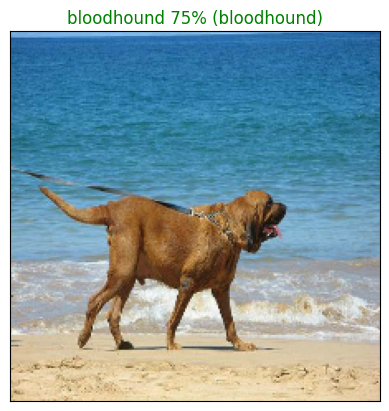

In [62]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=100)

### forgive me for being emotional about my first Deep Learning model take form and function... 🥇

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using get_pred_label().
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [63]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

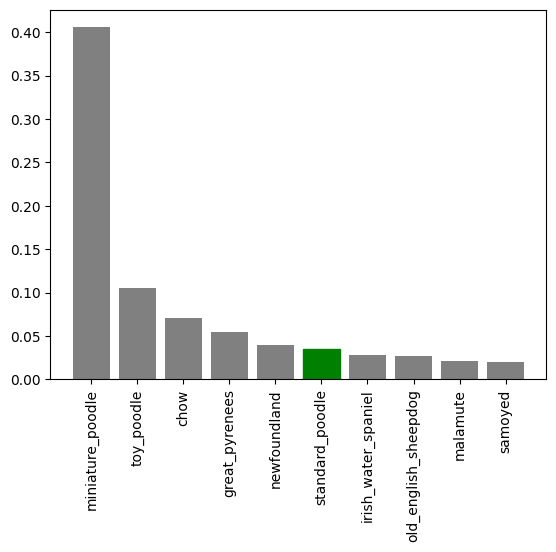

In [64]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=15)

Wonderful! Now we've got some functions to help us visualize our predictions and evaluate our model, let's check out a few.

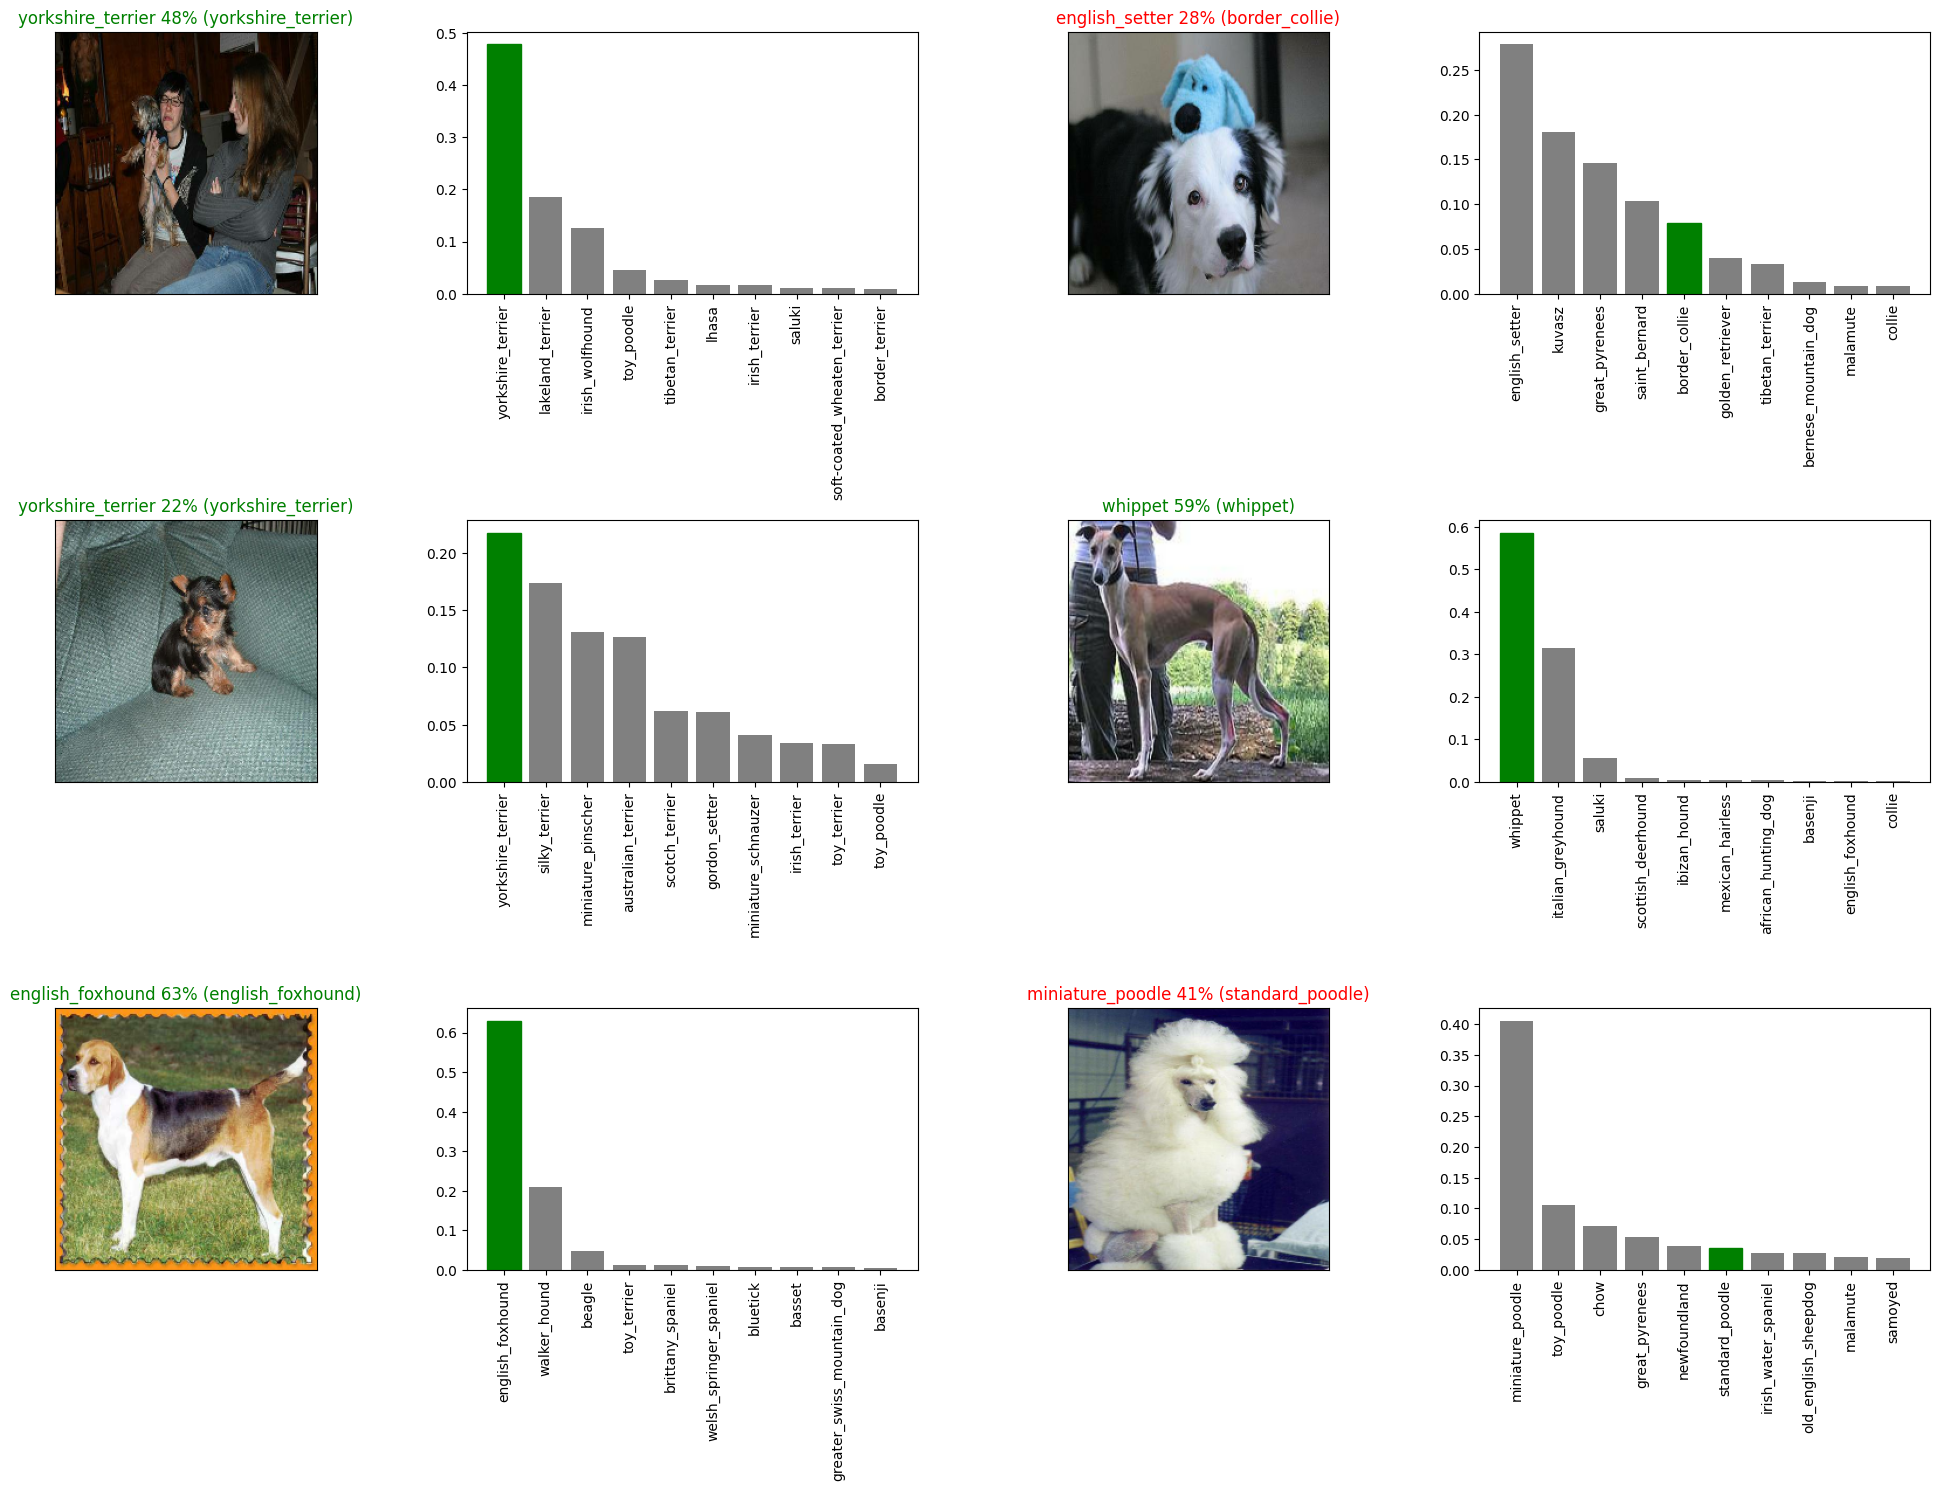

In [65]:
# Let's check a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.5)
plt.show()

## Saving and reloading our model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an entire saved Keras model is h5. So we'll make a function which can take a model as input and utilise the save() method to save it as a h5 file to a specified directory.

In [66]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y&m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # Save format of model
  print("Saving model to: {model_path}...")
  model.save(model_path)
  return model_path


If we've got a saved model, we'd like to load it, let's create a function which can take a model path and use the `tf.keras.models.load_model()` function to load it into the notebook.

In [67]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

And test of course

In [68]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: {model_path}...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Dog Vision/models/2023&m17-15021694962965-1000-images-Adam.h5'

In [69]:
# Load our model trained on 1000 images
model_1000_images = load_model("drive/MyDrive/Dog Vision/models/2023&m15-23551694822147-1000-images-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/models/2023&m15-23551694822147-1000-images-Adam.h5


#### Now let's compare the existing model with the loaded one to ensure its airtight

In [70]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 71ms/step - loss: 1.2713 - accuracy: 0.7100


[1.2713212966918945, 0.7099999785423279]

In [71]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 1s 78ms/step - loss: 1.2697 - accuracy: 0.6900


[1.2697339057922363, 0.6899999976158142]

### Looks great!

## Training a model (On the full data)

In [72]:
# Remind ourselves of the size of the full dataset
len(X), len(y)

(10222, 10222)

we can use our `create_data_batches()` function from above which also preprocesses our images for us (thank you past us for writing a helpful function).

In [73]:
full_data = create_data_batches(X, y)

Creating training data batches...


we've got a function for creating a model too :) Let's use `create_model()` to instantiate another model.

In [74]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [75]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [76]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

Reusing TensorBoard on port 6006 (pid 8066), started 0:00:12 ago. (Use '!kill 8066' to kill it.)

<IPython.core.display.Javascript object>




### I think we can press the **RED** buttun

**Note:** Since running the cell below will cause the model to train on all of the data (10,000+) images, it may take a fairly long time to get started and finish. However, thanks to our full_model_early_stopping callback, it'll stop before it starts going too long.

In [77]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 35s 96ms/step - loss: 1.3427 - accuracy: 0.6653
Epoch 2/100
320/320 [==============================] - 31s 95ms/step - loss: 0.4025 - accuracy: 0.8802
Epoch 3/100
320/320 [==============================] - 32s 99ms/step - loss: 0.2351 - accuracy: 0.9355
Epoch 4/100
320/320 [==============================] - 30s 94ms/step - loss: 0.1536 - accuracy: 0.9638
Epoch 5/100
320/320 [==============================] - 30s 94ms/step - loss: 0.1061 - accuracy: 0.9797
Epoch 6/100
320/320 [==============================] - 30s 92ms/step - loss: 0.0768 - accuracy: 0.9883
Epoch 7/100
320/320 [==============================] - 30s 93ms/step - loss: 0.0585 - accuracy: 0.9907
Epoch 8/100
320/320 [==============================] - 30s 93ms/step - loss: 0.0459 - accuracy: 0.9944
Epoch 9/100
320/320 [==============================] - 30s 92ms/step - loss: 0.0374 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 30s 92ms/step - l

In [78]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

Saving model to: {model_path}...


'drive/MyDrive/Dog Vision/models/2023&m17-15161694963775-all-images-Adam.h5'

In [80]:
# Load in the full model
loaded_full_model = load_model('/content/drive/MyDrive/Dog Vision/models/2023&m17-15161694963775-all-images-Adam.h5')

Loading saved model from: /content/drive/MyDrive/Dog Vision/models/2023&m17-15161694963775-all-images-Adam.h5


### Making predictins on the test dataset

To make predictions on the test data, we'll:

* Get the test image filenames.
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the predict() function.

In [81]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "drive/MyDrive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['drive/MyDrive/Dog Vision/test/e5fc0207e1db00fa778b00832f622b10.jpg',
 'drive/MyDrive/Dog Vision/test/dfe03aa0ae066e09cdda6e7f6e08390a.jpg',
 'drive/MyDrive/Dog Vision/test/e48e4d9137c69e69f54f85907c061172.jpg',
 'drive/MyDrive/Dog Vision/test/e73dc6a8f2d7c941f28c0a5298bc5bdc.jpg',
 'drive/MyDrive/Dog Vision/test/de90fcd52b9c527ea097d88804985516.jpg',
 'drive/MyDrive/Dog Vision/test/e48f3d4f0514a07f4777a30f01d32ea9.jpg',
 'drive/MyDrive/Dog Vision/test/e6353a9420e1e529b6c20b9414786ae7.jpg',
 'drive/MyDrive/Dog Vision/test/dd51cac7c6e1e091b26545aec86dabf3.jpg',
 'drive/MyDrive/Dog Vision/test/e293d06016cac647cd289e2008a4623a.jpg',
 'drive/MyDrive/Dog Vision/test/dcdaf98ba8979ac0373d6dce63872053.jpg']

In [82]:
# How many test images are there?
len(test_filenames)

10357

In [83]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


**Note:** Since there are 10,000+ test images, making predictions could take a while, even on a GPU. So beware running the cell below may take up to an hour.

In [84]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 169s 509ms/step


In [85]:
# Check out the test predictions
test_predictions[:10]

array([[1.3686558e-11, 9.7987634e-12, 4.7029427e-08, ..., 1.6020716e-04,
        2.5865133e-12, 9.3751842e-09],
       [3.8878591e-11, 7.7424102e-07, 3.2951825e-10, ..., 9.8116723e-12,
        6.3773195e-13, 1.1175165e-11],
       [9.7418358e-11, 2.1559796e-07, 9.7791368e-01, ..., 8.4402970e-08,
        5.1506938e-10, 3.7023224e-09],
       ...,
       [1.7091853e-09, 6.6496538e-15, 4.3116341e-10, ..., 5.9990929e-11,
        1.0972826e-09, 1.4491253e-10],
       [3.7100983e-10, 3.4683235e-11, 1.5146413e-10, ..., 1.4220137e-14,
        3.6281742e-13, 4.9494533e-04],
       [7.6655612e-11, 8.1632419e-16, 1.5675975e-13, ..., 5.2527361e-05,
        2.0397964e-07, 1.8850779e-10]], dtype=float32)

### Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [86]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [87]:
# Append test image ID's to predictions DataFrame
test_path = "drive/MyDrive/Dog Vision/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

id affenpinscher afghan_hound  \
0  e5fc0207e1db00fa778b00832f622b10           NaN          NaN   
1  dfe03aa0ae066e09cdda6e7f6e08390a           NaN          NaN   
2  e48e4d9137c69e69f54f85907c061172           NaN          NaN   
3  e73dc6a8f2d7c941f28c0a5298bc5bdc           NaN          NaN   
4  de90fcd52b9c527ea097d88804985516           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [88]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e5fc0207e1db00fa778b00832f622b10   1.368656e-11  9.798763e-12   
1  dfe03aa0ae066e09cdda6e7f6e08390a   3.887859e-11  7.742410e-07   
2  e48e4d9137c69e69f54f85907c061172   9.741836e-11  2.155980e-07   
3  e73dc6a8f2d7c941f28c0a5298bc5bdc   5.334845e-11  8.661926e-13   
4  de90fcd52b9c527ea097d88804985516   6.149775e-09  6.935148e-07   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         4.702943e-08  1.816756e-03                    3.719369e-12   
1         3.295182e-10  1.401386e-10                    1.587518e-10   
2         9.779137e-01  3.762192e-08                    1.129614e-13   
3         7.470210e-13  1.267315e-12                    1.209651e-03   
4         2.973978e-13  2.539396e-09                    1.966711e-13   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.137332e-13        7.076285e-10  9.387506e-07  2.439985e-08  ...   
1  7.600759e-14        1.548944e-13  1.374061e-13  9.020874e-11  ...   
2  2.808798e-10        4.897538e-08  9.476356e-07  4.471613e-10  ...   
3  3.080500e-02        1.671664e-11  3.550627e-05  5.800833e-12  ...   
4  2.524751e-11        7.412136e-12  5.998173e-11  2.123570e-14  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  6.065354e-11  2.124794e-11  1.507608e-06  5.532023e-11  9.980661e-05   
1  2.486415e-13  5.289692e-11  3.508269e-12  5.122437e-12  2.308362e-11   
2  1.770971e-07  4.009638e-09  2.273434e-09  3.055006e-09  2.932200e-08   
3  7.268212e-10  1.393153e-09  2.106929e-09  1.187876e-08  9.194973e-08   
4  1.483356e-07  7.026780e-15  1.793197e-11  4.032754e-08  3.687500e-12   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            2.329875e-08                 9.881547e-13  1.602072e-04   
1            5.415427e-13                 4.828917e-13  9.811672e-12   
2            4.498428e-08                 5.002396e-09  8.440297e-08   
3            4.948930e-11                 9.821139e-11  6.856059e-01   
4            1.437973e-10                 1.420024e-12  3.890077e-12   

   wire-haired_fox_terrier  yorkshire_terrier  
0             2.586513e-12       9.375184e-09  
1             6.377319e-13       1.117516e-11  
2             5.150694e-10       3.702322e-09  
3             1.815323e-10       1.214910e-12  
4             3.484904e-11       1.689487e-10  

[5 rows x 121 columns]

In [90]:
preds_df.to_csv("drive/MyDrive/Dog Vision/full_submission_1_mobilienetV2_adam.csv",
                 index=False) # exports our predictions DataFrame to CSV so we can submit it to Kaggle.

## Making predictions on custom images

if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [92]:
# Get custom image filepaths from my uploaded dog photos (I just uploaded some dog photos to a drive folder)
custom_path = "drive/MyDrive/Dog Vision/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)

SyntaxError: ignored

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

Since our early experiment (using only 1000 images) hinted at our model overfitting (the results on the training set far outperformed the results on the validation set), one goal going forward would be to try and prevent it.

We can use:

1. Trying another model from TensorFlow Hub - Perhaps a different model would perform better on our dataset. One option would be to experiment with a different pre-trained model from TensorFlow Hub or look into the tf.keras.applications module.

2. **Data augmentation** - Take the training images and manipulate (crop, resize) or distort them (flip, rotate) to create even more training data for the model to learn from. Check out the TensorFlow images documentation for a whole bunch of functions you can use on images. A great idea would be to try and replicate the techniques in this example cat vs. dog image classification notebook for our dog breeds problem.

3. **Fine-tuning** - The model we used in this notebook was directly from TensorFlow Hub, we took what it had already learned from another dataset (ImageNet) and applied it to our own. Another option is to use what the model already knows and fine-tune this knowledge to our own dataset (pictures of dogs). This would mean all of the patterns within the model would be updated to be more specific to pictures of dogs rather than general images.
